In [35]:
from langchain_qdrant import QdrantVectorStore, FastEmbedSparse, RetrievalMode
from langchain_core.vectorstores.base import VectorStoreRetriever
from qdrant_client import QdrantClient
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
# from langchain_classic.retrievers import create_retrieval_chain
import os
from dotenv import load_dotenv
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

from dataclasses import dataclass
from typing import List
from langchain_core.documents import Document
import re
from langchain_core.tools import Tool
from typing import List, Annotated
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage
load_dotenv()



True

In [36]:
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=2000))
arxiv_tool = ArxivQueryRun(api_wrapper= ArxivAPIWrapper(top_k_results=4, doc_content_chars_max= 2000))

In [37]:
class ProcessUserQuery:

    def __init__(self):
        
    
        self.qdrant_url = os.getenv('QDRANT_API_URL')
        self.qdrant_key = os.getenv('QDRANT_API_KEY')
        self.client = QdrantClient(
            url=self.qdrant_url,
            api_key=self.qdrant_key
        )
        self.denseEmbedding = HuggingFaceEmbeddings(
            model = 'sentence-transformers/all-MiniLM-L12-v2'
        )
        self.sparseEmbedding = FastEmbedSparse('qdrant/bm25')
        self.collectionName = os.getenv('COLLECTIONNAME')
        self.llm = ChatGroq(model="openai/gpt-oss-20b")

    @property 
    def QdrantReceiver(self) -> VectorStoreRetriever:

        return QdrantVectorStore(
            collection_name= self.collectionName,
            client=self.client,
            embedding= self.denseEmbedding,
            sparse_embedding= self.sparseEmbedding,
            retrieval_mode=RetrievalMode.HYBRID
        ).as_retriever(
            search_type = 'mmr',
            search_kwarg = {"k": 3}
        )
    
    def getllm(self):
        return self.llm

In [38]:
obj = ProcessUserQuery()
receiver = obj.QdrantReceiver


In [39]:


def retriver_tool_function(query : str) -> str:

    docs = receiver.invoke(query)
    return '\n\n'.join([doc.page_content for doc in docs])

In [40]:
powerbi_Retriver = Tool(
    func = retriver_tool_function,
    name="PowerBIRetriver",
    description= "Power BI Retriver"
)

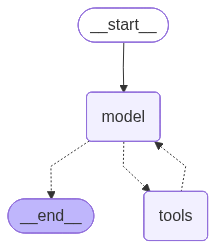

In [41]:
from langchain.agents import create_agent
tools = [powerbi_Retriver, wiki_tool]

system_prompt = "You are a helpful assistant that can access tools to answer questions."


## create the native Langgraph react agent
react_node=create_agent(model=obj.getllm(),tools=tools, system_prompt=system_prompt)
react_node

In [42]:
@dataclass
class MyastreamBot:
    messages: Annotated[List[AnyMessage], add_messages]

In [43]:
graph = StateGraph(MyastreamBot)

graph.add_node("llmAgent", react_node)
graph.add_edge(START, "llmAgent")
graph.add_edge("llmAgent", END)

graph_builder = graph.compile()

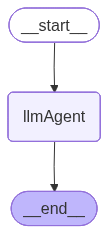

In [44]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [49]:
msg = "What is Power BI also is Power BI details available in Wikipedia"
result = graph_builder.invoke(MyastreamBot(messages=[HumanMessage(msg)]))
for item in result['messages']:
    item.pretty_print()


================================ Human Message =================================

What is Power BI also is Power BI details available in Wikipedia
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fc_1b5384fb-1f46-4142-a605-2bf120f33701)
 Call ID: fc_1b5384fb-1f46-4142-a605-2bf120f33701
  Args:
    query: Power BI
================================= Tool Message =================================
Name: wikipedia

Page: Microsoft Power BI
Summary: Microsoft Power BI is an interactive data visualization software product developed by Microsoft with a primary focus on business intelligence (BI). It is part of the Microsoft Power Platform.
Power BI is a collection of software services, apps, and connectors that work together to turn various sources of data into static and interactive data visualizations. Data may be input by reading directly from a database, webpage, PDF, or structured files such as spreadsheets, CSV, XML,  JSON, XLSX, an